## Step 1: Data Collection and Preprocessing

### BTS Data for Southwest Region

In [ ]:
import requests
import pandas as pd
import zipfile
import io
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime

SOUTHWEST_STATE_AIRPORTS = {
    # Arizona
    "PHX", "TUS", "FLG", "YUM", "AZA",
    # New Mexico
    "ABQ", "SAF", "ROW", "HOB",
    # Texas
    "DFW", "DAL", "HOU", "AUS", "SAT", "ELP", "LBB", "MAF", "AMA", "CRP", "HRL", "MFE", "BRO", "TYR", "SJT", "ACT",
    # Oklahoma
    "OKC", "TUL", "LAW", "SWO", "END",
    # California
    "LAX", "SAN", "SFO", "OAK", "SJC", "BUR", "LGB", "SMF", "PSP", "SNA", "FAT", "ONT", "SBA", "BFL"
}

OUTPUT_FOLDER = "new_bts_data"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

def download_bts_data(year, month):
    """Download BTS data for a specific month"""
    url = f'https://www.transtats.bts.gov/PREZIP/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_{year}_{month}.zip'
    
    try:
        response = requests.get(
            url, 
            headers={'User-Agent': 'Mozilla/5.0'},
            timeout=300,
            stream=True
        )
        response.raise_for_status()
        
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            csv_file = next((name for name in z.namelist() if name.endswith('.csv')), None)
            if not csv_file:
                return (year, month, None, "No CSV in zip")
            
            with z.open(csv_file) as f:
                df = pd.read_csv(f, encoding='utf-8', low_memory=False)
            
            df = df[
                (df["Reporting_Airline"] == "WN") &
                (df["Origin"].isin(SOUTHWEST_STATE_AIRPORTS))
            ]
            
            if not df.empty:
                month_filename = os.path.join(OUTPUT_FOLDER, f"bts_wn_{year}_{month:02d}.csv")
                df.to_csv(month_filename, index=False)
                print(f"Saved {year}-{month:02d}: {len(df):,} rows to {month_filename}")
            
            return (year, month, df, None)
            
    except requests.exceptions.HTTPError as e:
        return (year, month, None, f"HTTP {e.response.status_code}")
    except Exception as e:
        return (year, month, None, str(e)[:50])

def download_years_parallel(start_year, end_year, max_workers=12):
    """Download multiple years of data with maximum parallelization"""
    months_to_download = []
    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            current_date = datetime.now()
            if year > current_date.year or (year == current_date.year and month > current_date.month):
                continue
            months_to_download.append((year, month))
    
    total_months = len(months_to_download)
    print(f"Downloading {total_months} months ({start_year}-{end_year})")
    print(f"Using {max_workers} parallel workers\n")
    
    results = {}
    start_time = datetime.now()
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(download_bts_data, year, month): (year, month)
            for year, month in months_to_download
        }
        
        for future in as_completed(futures):
            year, month, df, error = future.result()
            if df is not None and not df.empty:
                results[(year, month)] = df
            else:
                print(f"✗ {year}-{month:02d}: {error or 'No matching rows'}")
    
    elapsed = (datetime.now() - start_time).total_seconds() / 60
    print(f"\nFinished in {elapsed:.1f} minutes")
    
    successful = [df for df in results.values() if df is not None]
    if successful:
        combined_df = pd.concat(successful, ignore_index=True)
        print(f"Combined total: {len(combined_df):,} rows")
        return combined_df
    else:
        print("No data downloaded")
        return None

def save_to_csv_fast(df, filename):
    """Save filtered DataFrame to CSV"""
    print(f"\nSaving combined dataset to {filename}...")
    start = datetime.now()
    df.to_csv(filename, index=False)
    elapsed = (datetime.now() - start).total_seconds()
    size_mb = os.path.getsize(filename) / (1024 * 1024)
    print(f"Saved in {elapsed:.1f}s ({size_mb:.1f} MB)")

if __name__ == "__main__":
    START_YEAR = 2015 # 10 years worth of data
    END_YEAR = 2025
    MAX_WORKERS = 10

    combined_data = download_years_parallel(START_YEAR, END_YEAR, max_workers=MAX_WORKERS)
    
    if combined_data is not None:
        output_file = os.path.join(OUTPUT_FOLDER, f"bts_wn_southwest_combined_{START_YEAR}_{END_YEAR}.csv")
        save_to_csv_fast(combined_data, output_file)
        print(f"\nCombined file saved as {output_file} ({len(combined_data):,} rows)")
        print("\nHead of combined dataset:")
        print(combined_data.head())
    else:
        print("No data available after filtering.")

Using 10 parallel workers

✓ Saved 2015-02: 33,538 rows to new_bts_data\bts_wn_2015_02.csv
✓ Saved 2015-02: 33,538 rows to new_bts_data\bts_wn_2015_02.csv
✓ Saved 2015-03: 38,907 rows to new_bts_data\bts_wn_2015_03.csv
✓ Saved 2015-03: 38,907 rows to new_bts_data\bts_wn_2015_03.csv
✓ Saved 2015-08: 40,031 rows to new_bts_data\bts_wn_2015_08.csv
✓ Saved 2015-04: 38,486 rows to new_bts_data\bts_wn_2015_04.csv
✓ Saved 2015-08: 40,031 rows to new_bts_data\bts_wn_2015_08.csv
✓ Saved 2015-04: 38,486 rows to new_bts_data\bts_wn_2015_04.csv
✓ Saved 2015-10: 39,441 rows to new_bts_data\bts_wn_2015_10.csv
✓ Saved 2015-10: 39,441 rows to new_bts_data\bts_wn_2015_10.csv
✓ Saved 2015-07: 40,945 rows to new_bts_data\bts_wn_2015_07.csv
✓ Saved 2015-07: 40,945 rows to new_bts_data\bts_wn_2015_07.csv
✓ Saved 2015-05: 39,030 rows to new_bts_data\bts_wn_2015_05.csv
✓ Saved 2015-05: 39,030 rows to new_bts_data\bts_wn_2015_05.csv
✓ Saved 2015-09: 37,855 rows to new_bts_data\bts_wn_2015_09.csv
✓ Saved 2015-

### Meteostat Weather Data

In [ ]:
from meteostat import Point, Daily
import pandas as pd
from datetime import datetime
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
import time

SWA_AIRPORTS = {
    "DAL": (32.8471, -96.8517),
    "AUS": (30.1975, -97.6664),
    "HOU": (29.6454, -95.2789),
    "SAT": (29.5337, -98.4698),
    "ELP": (31.8070, -106.3779),
    "LBB": (33.6609, -101.8214),
    "MAF": (31.9369, -102.2016),
    "HRL": (26.2285, -97.6544),
    "LAX": (33.9425, -118.4081),
    "OAK": (37.7126, -122.2197),
    "SAN": (32.7338, -117.1933),
    "SJC": (37.3639, -121.9289),
    "SMF": (38.6950, -121.5908),
    "BUR": (34.2007, -118.3587),
    "ONT": (34.0559, -117.6009),
    "SNA": (33.6757, -117.8682),
    "MCO": (28.4312, -81.3081),
    "TPA": (27.9755, -82.5332),
    "FLL": (26.0726, -80.1527),
    "PBI": (26.6832, -80.0956),
    "RSW": (26.5362, -81.7552),
    "PNS": (30.4734, -87.1867),
    "JAX": (30.4941, -81.6879),
    "PHX": (33.4342, -112.0116),
    "TUS": (32.1161, -110.9410),
    "DEN": (39.8561, -104.6737),
    "LAS": (36.0801, -115.1522),
    "RNO": (39.4993, -119.7681),
    "MDW": (41.7868, -87.7522),
    "ATL": (33.6407, -84.4277),
    "BWI": (39.1754, -76.6684),
    "STL": (38.7487, -90.3700),
    "MCI": (39.2976, -94.7139),
    "BNA": (36.1245, -86.6782),
    "MEM": (35.0425, -89.9767),
    "ABQ": (35.0494, -106.6172),
    "OKC": (35.3931, -97.6008),
    "TUL": (36.1986, -95.8880),
    "MSY": (29.9934, -90.2580),
    "RDU": (35.8776, -78.7875),
    "CLT": (35.2140, -80.9431),
    "PHL": (39.8719, -75.2411),
    "PIT": (40.4915, -80.2328),
    "BOS": (42.3656, -71.0096),
    "BUF": (42.9405, -78.7322),
    "ALB": (42.7483, -73.8026),
    "ROC": (43.1181, -77.6721),
    "ISP": (40.7953, -73.1000),
    "CMH": (39.9973, -82.8876),
    "CLE": (41.4117, -81.8498),
    "IND": (39.7173, -86.2944),
    "MSP": (44.8848, -93.2223),
    "MKE": (42.9473, -87.8960),
    "DTW": (42.2162, -83.3554),
    "GRR": (42.8808, -85.5228),
    "SLC": (40.7884, -111.9777),
    "SEA": (47.4490, -122.3093),
    "GEG": (47.6269, -117.5331),
    "PDX": (45.5898, -122.5951),
    "ICT": (37.6528, -97.4331),
    "LIT": (34.7275, -92.2241),
    "SDF": (38.1740, -85.7368),
    "DSM": (41.5341, -93.6600),
    "OMA": (41.3025, -95.8941),
    "BHM": (33.5629, -86.7536),
    "RIC": (37.5052, -77.3191),
    "ORF": (36.8946, -76.2015),
    "BDL": (41.9389, -72.6839),
    "PVD": (41.7246, -71.4283),
    "MHT": (42.9327, -71.4350)
}

OUTPUT_DIR = Path("meteostat_daily")
OUTPUT_DIR.mkdir(exist_ok=True)

START_YEAR = 2015
END_YEAR = 2025
MAX_WORKERS = 4

def fetch_airport_daily(airport, coords):
    lat, lon = coords
    point = Point(lat, lon)
    all_data = []
    
    for year in range(START_YEAR, END_YEAR + 1):
        start = datetime(year, 1, 1)
        end = datetime(year, 12, 31)
        try:
            data = Daily(point, start, end).fetch()
            if not data.empty:
                data = data.reset_index().rename(columns = {"time": "date"})
                data['airport'] = airport
                all_data.append(data)
                print(f"Fetched {airport} {year} ({len(data)} rows)")
        except Exception as e:
            print(f"Error fetching {airport} {year}: {e}")
        time.sleep(0.05)
    
    if all_data:
        df = pd.concat(all_data)
        out_file = OUTPUT_DIR / f"{airport}.csv"
        df.to_csv(out_file, index=True)
        print(f"Saved {airport} to {out_file}")

def main():
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = [executor.submit(fetch_airport_daily, airport, coords)
                   for airport, coords in SWA_AIRPORTS.items()]
        for fut in as_completed(futures):
            fut.result()

    all_files = list(OUTPUT_DIR.glob("*.csv"))
    combined = pd.concat((pd.read_csv(f, index_col=0) for f in all_files), ignore_index=True)
    combined.to_csv(OUTPUT_DIR / "weather_data.csv", index=False)
    print(f"\nAll airports combined: {len(combined)} rows")

if __name__ == "__main__":
    main()

⚠️ Error fetching AUS 2015: fetch() got an unexpected keyword argument 'units'
⚠️ Error fetching HOU 2015: fetch() got an unexpected keyword argument 'units'
⚠️ Error fetching SAT 2015: fetch() got an unexpected keyword argument 'units'
⚠️ Error fetching DAL 2015: fetch() got an unexpected keyword argument 'units'
⚠️ Error fetching AUS 2016: fetch() got an unexpected keyword argument 'units'
⚠️ Error fetching HOU 2016: fetch() got an unexpected keyword argument 'units'
⚠️ Error fetching SAT 2016: fetch() got an unexpected keyword argument 'units'
⚠️ Error fetching DAL 2016: fetch() got an unexpected keyword argument 'units'
⚠️ Error fetching AUS 2016: fetch() got an unexpected keyword argument 'units'
⚠️ Error fetching HOU 2016: fetch() got an unexpected keyword argument 'units'
⚠️ Error fetching SAT 2016: fetch() got an unexpected keyword argument 'units'
⚠️ Error fetching DAL 2016: fetch() got an unexpected keyword argument 'units'
⚠️ Error fetching AUS 2017: fetch() got an unexpecte

ValueError: No objects to concatenate

### Joining BTS and Meteostat Data

In [ ]:
import polars as pl
import zipfile
import io

with zipfile.ZipFile("combined_data.zip") as z:
    csv_name = next(name for name in z.namelist() if name.endswith(".csv"))
    flights = pl.scan_csv(io.BytesIO(z.read(csv_name)), low_memory=True)

weather = pl.scan_csv("Meteostat_daily_2000-2025.csv", low_memory=True)

joined = flights.join(
    weather,
    how="inner",
    left_on=["Origin", "FlightDate"],
    right_on=["airport", "date"]
)

joined.sink_csv("joined_data.csv")

print("Streaming join completed successfully. File saved as 'joined_data.csv'")

✅ Streaming join completed successfully. File saved as 'joined_data.csv'


### Converting to Imperial

In [3]:
import pandas as pd
df = pd.read_csv("Data/FINAL_DATASET.csv")

# Temperature: Convert °C to °F
for col in ["tavg", "tmin", "tmax"]:
    if col in df.columns:
        df[col] = (df[col] * 9/5 + 32).round().astype("Int64")

# Precipitation & Snow: Convert mm to inches
for col in ["prcp", "snow"]:
    if col in df.columns:
        df[col] = df[col] / 25.4

# Wind Speed: Convert km/h to mph
if "wspd" in df.columns:
    df["wspd"] = df["wspd"] / 1.60934

# Pressure: Convert hPa to inHg
if "pres" in df.columns:
    df["pres"] = df["pres"] * 0.02953

print(df.head(1))

C:\Users\Pranav\AppData\Local\Temp\ipykernel_15644\2336550508.py:2: DtypeWarning: Columns (76,77,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Data/FINAL_DATASET.csv")


   Year  Quarter  Month  DayofMonth  DayOfWeek  FlightDate Reporting_Airline  \
0  2015        3      8           3          1  2015-08-03                WN   

   DOT_ID_Reporting_Airline IATA_CODE_Reporting_Airline Tail_Number  ...  \
0                     19393                          WN      N7743B  ...   

   tavg  tmin  tmax  prcp snow wdir       wspd  wpgt       pres  tsun  
0    81    71    94   0.0  0.0  NaN  10.501199   NaN  29.828253   NaN  

[1 rows x 120 columns]


### Treating Missing Values

In [4]:
# Percentage NA by column
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
percent_na = df.isna().mean() * 100
print(percent_na.sort_values(ascending = False).head(75))

# Removing >95% missing cols and IATA Code column due to redundancy
cols_to_drop = percent_na[percent_na > 95].index
df = df.drop(columns = cols_to_drop)
df = df.drop(columns = ["IATA_CODE_Reporting_Airline"])

print(f"\nDropped {len(cols_to_drop)} columns")
print("Remaining columns: ", len(df.columns))

# Printing percentage again
percent_na = df.isna().mean() * 100
print(percent_na.sort_values(ascending = False))

Div3WheelsOn            100.000000
Div3TotalGTime          100.000000
Div3LongestGTime        100.000000
Div3WheelsOff           100.000000
Div3TailNum             100.000000
Div5Airport             100.000000
Div5AirportID           100.000000
Div5AirportSeqID        100.000000
Div5WheelsOn            100.000000
Div5TotalGTime          100.000000
Div5LongestGTime        100.000000
Div5WheelsOff           100.000000
Div5TailNum             100.000000
Unnamed: 109            100.000000
wdir                    100.000000
Div4AirportSeqID        100.000000
Div4WheelsOn            100.000000
Div4TotalGTime          100.000000
Div4LongestGTime        100.000000
Div4WheelsOff           100.000000
Div4TailNum             100.000000
Div3AirportSeqID        100.000000
Div3AirportID           100.000000
Div3Airport             100.000000
Div4AirportID           100.000000
Div4Airport             100.000000
tsun                     99.999711
Div2WheelsOff            99.999578
Div2TailNum         

### Heatmap After Removing Highly Correlated and Unwanted Variables

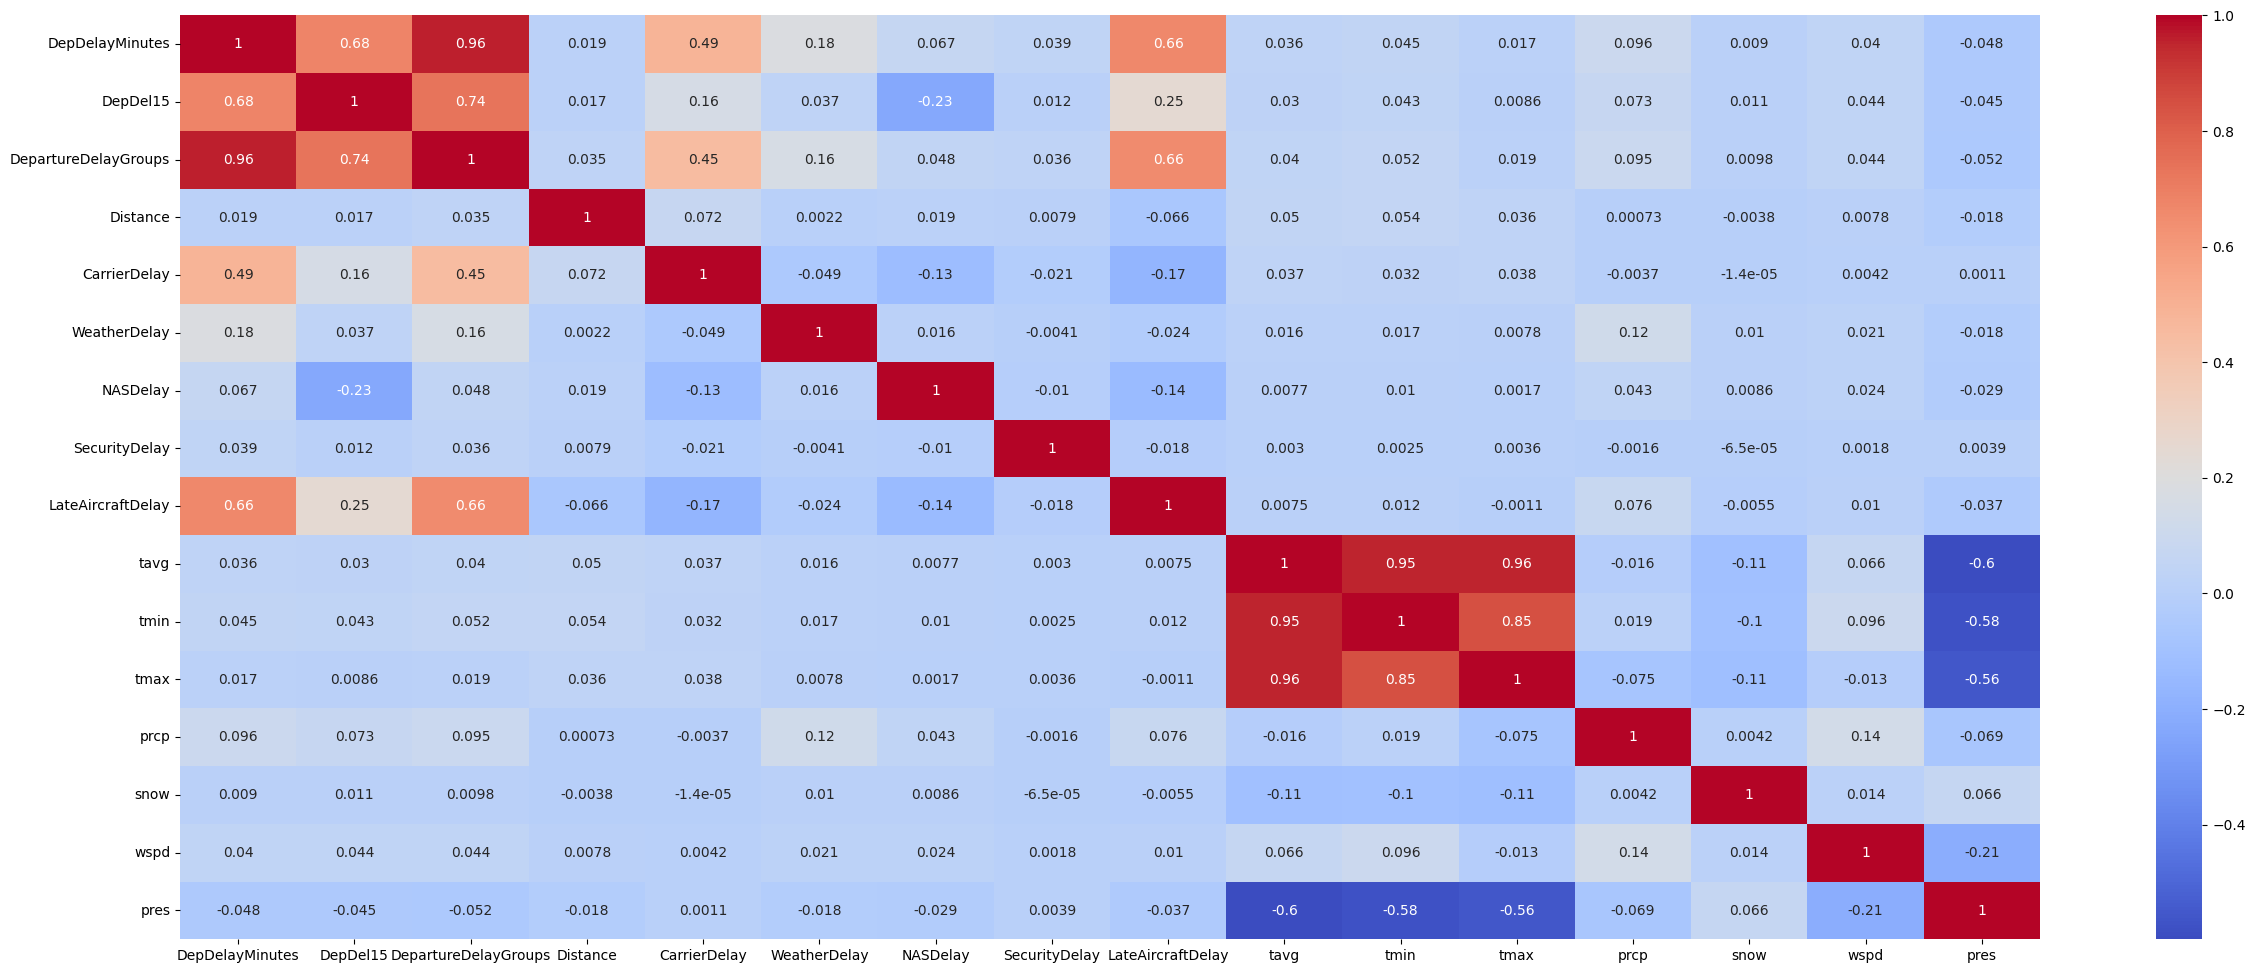

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

df = df.drop(columns = ['Tail_Number', 'ArrDel15', 'DepDelay', 'WheelsOn', 'WheelsOff', 'TaxiIn', 'TaxiOut', 'ArrTime', 'ArrDelay', 'ArrDelayMinutes', 'ArrivalDelayGroups', 'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 'DistanceGroup'])
numeric_df = df.select_dtypes(include = ['number']).drop(columns = ['DepTime', 'Year', 'Quarter', 'DayofMonth', 'DivAirportLandings', 'DestAirportSeqID', 'Flights', 'OriginAirportID', 'OriginStateFips', 'DestWac', 'OriginWac', 'CRSDepTime', 'CRSArrTime', 'Cancelled', 'DestStateFips', 'DayOfWeek', 'Month', 'DOT_ID_Reporting_Airline', 'Flight_Number_Reporting_Airline', 'OriginCityMarketID', 'Diverted', 'OriginAirportSeqID', 'DestAirportID', 'DestCityMarketID'], errors = 'ignore')
plt.figure(figsize = (30, 12))
sns.heatmap(numeric_df.corr(), annot = True, cmap = "coolwarm")
plt.show()

In [6]:
percent_na = df.isna().mean() * 100
print(percent_na.sort_values(ascending = False))

LateAircraftDelay                  81.187155
SecurityDelay                      81.187155
NASDelay                           81.187155
WeatherDelay                       81.187155
CarrierDelay                       81.187155
snow                               56.432448
DepDel15                            1.899147
DepartureDelayGroups                1.899147
DepTime                             1.899147
DepDelayMinutes                     1.899147
prcp                                0.458100
pres                                0.073344
tmin                                0.008974
tmax                                0.008974
wspd                                0.000844
tavg                                0.000244
Year                                0.000000
Quarter                             0.000000
Month                               0.000000
DayofMonth                          0.000000
DestAirportSeqID                    0.000000
DestAirportID                       0.000000
OriginWac 

In [22]:
print("Dimension: ", df.shape)
# tavg missing rows
num_missing = df['tavg'].isna().sum()
print("tavg missing rows:", num_missing)

# wspd missing rows
num_missing = df['tmin'].isna().sum()
print("wspd missing rows:", num_missing)

# tmax missing rows
num_missing = df['tmax'].isna().sum()
print("tmax missing rows:", num_missing)

# tmin missing rows
num_missing = df['tmin'].isna().sum()
print("tmin missing rows:", num_missing)

# pres missing rows
num_missing = df['pres'].isna().sum()
print("pres missing rows:", num_missing)

# tmin missing rows
num_missing = df['prcp'].isna().sum()
print("prcp missing rows:", num_missing)

# snow missing rows
num_missing = df['snow'].isna().sum()
print("snow missing rows:", num_missing)

# delay missing rows
num_missing = df['DepDelayMinutes'].isna().sum()
print("delay missing rows:", num_missing)

Dimension:  (4101558, 52)
tavg missing rows: 0
wspd missing rows: 0
tmax missing rows: 0
tmin missing rows: 0
pres missing rows: 0
prcp missing rows: 0
snow missing rows: 0
delay missing rows: 0


In [21]:
# df['tavg'] = df['tavg'].fillna(((df['tmin'] + df['tmax']) / 2).round().astype('Int64'))

# Snow
# df['snow'] = df['snow'].fillna(
#     df.groupby(['Origin', 'FlightDate'])['snow'].transform('mean')
# )

# df['tmin'] = df['tmin'].fillna(
#     df.groupby(['Origin', 'FlightDate'])['tmin'].transform('mean')
# )

# df['tmax'] = df['tmax'].fillna(
#     df.groupby(['Origin', 'FlightDate'])['tmax'].transform('mean')
# )

# df['wspd'] = df['wspd'].fillna(
#     df.groupby(['Origin', 'FlightDate'])['wspd'].transform('mean')
# )

# df['pres'] = df['pres'].fillna(
#     df.groupby(['Origin', 'FlightDate'])['pres'].transform('mean')
# )

# df['prcp'] = df['prcp'].fillna(
#     df.groupby(['Origin', 'FlightDate'])['prcp'].transform('mean')
# )

# df['snow'] = df['snow'].fillna(
#     df.groupby('Origin')['snow'].transform('mean')
# )

# df['DepDelayMinutes'] = df['DepDelayMinutes'].fillna(
#     df.groupby(['Origin', 'FlightDate'])['DepDelayMinutes'].transform('mean')
# )

df = df.dropna(subset = ['DepDelayMinutes', 'snow', 'wspd', 'tmax', 'tmin', 'pres', 'prcp'])

## Delays Over Time

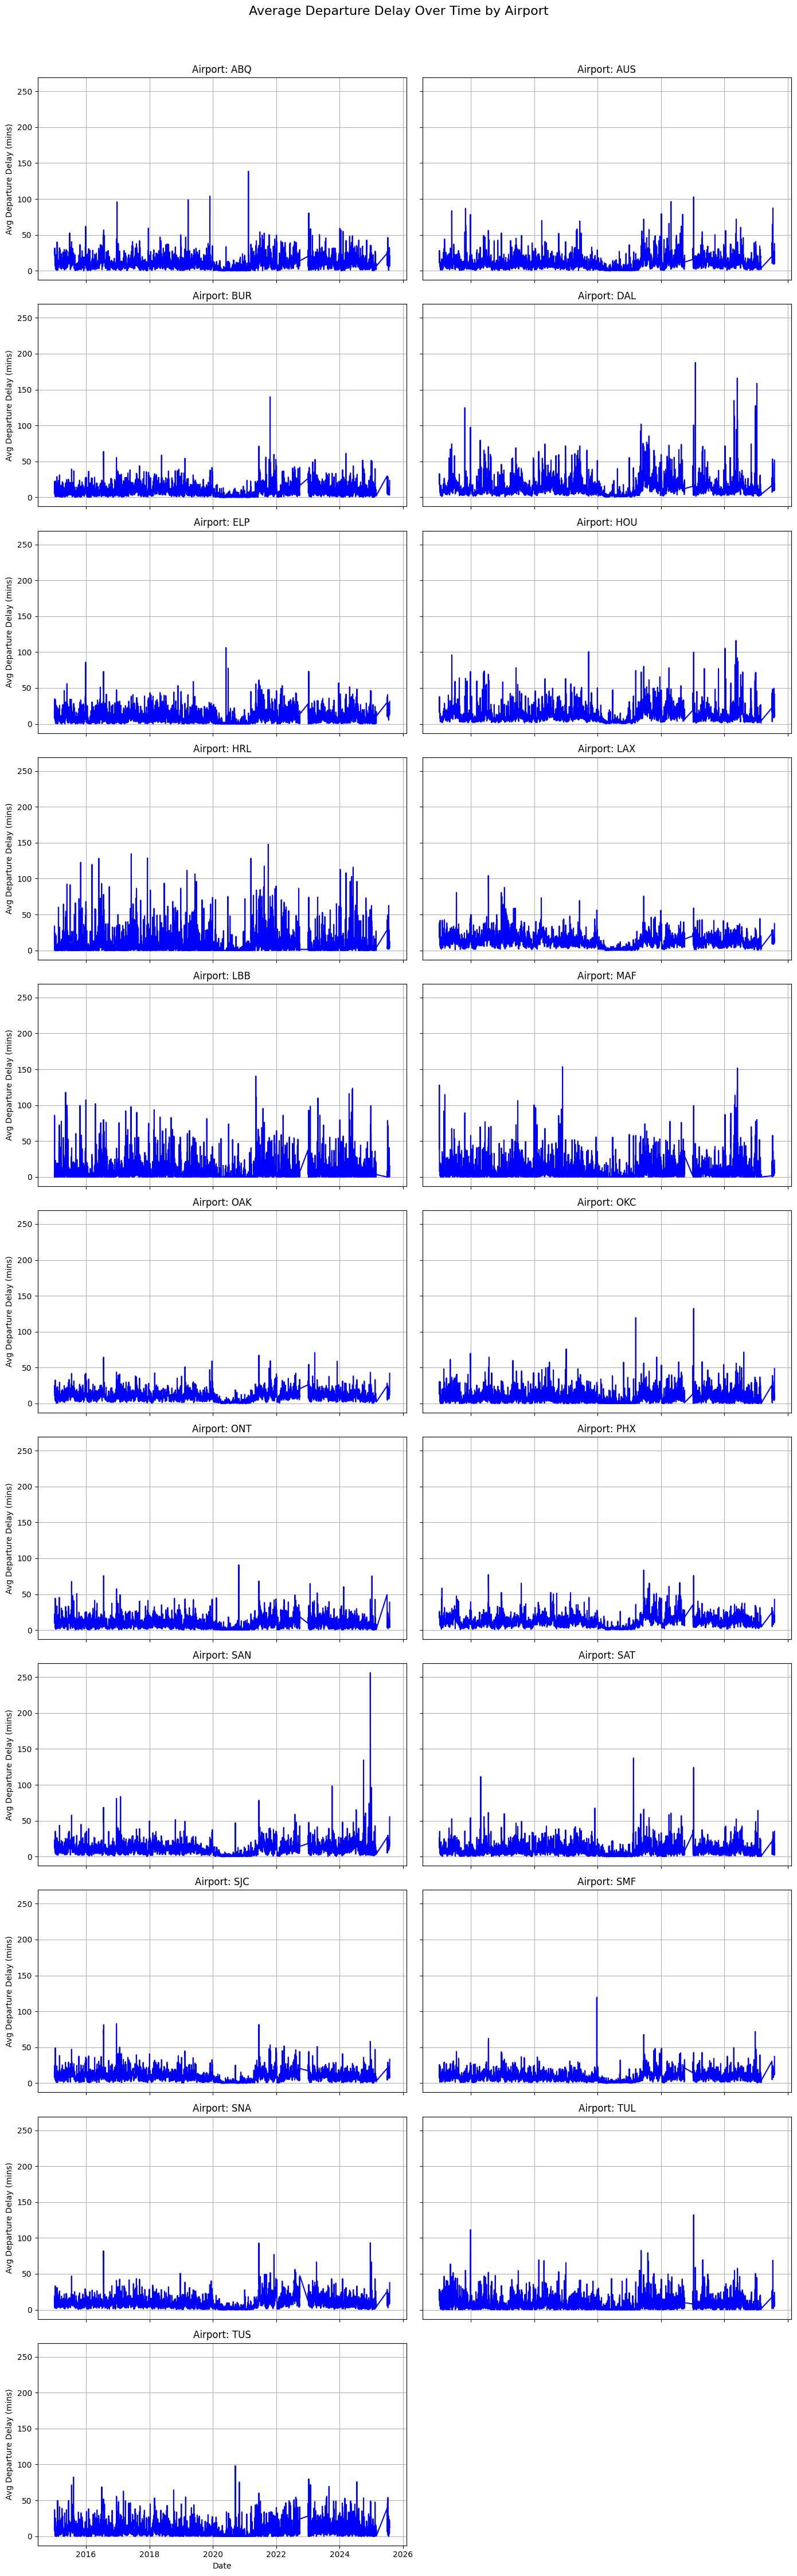

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure date column is datetime
df['FlightDate'] = pd.to_datetime(df['FlightDate'])

# ------------------------
# 2️⃣ Aggregate: average delay per day per airport
# ------------------------
avg_delay = (
    df.groupby(['FlightDate', 'Origin'])['DepDelayMinutes']
      .mean()
      .reset_index()
)

# ------------------------
# 3️⃣ Get unique airports
# ------------------------
airports = avg_delay['Origin'].unique()
num_airports = len(airports)

# ------------------------
# 4️⃣ Create subplots (one per airport)
# ------------------------
# Calculate number of rows and columns for subplots
cols = 2  # Adjust if you want more columns
rows = (num_airports + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(14, 4*rows), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten to easily index

# Plot each airport
for i, airport in enumerate(airports):
    airport_data = avg_delay[avg_delay['Origin'] == airport]
    sns.lineplot(
        data=airport_data,
        x='FlightDate',
        y='DepDelayMinutes',
        ax=axes[i],
        color='blue'
    )
    axes[i].set_title(f"Airport: {airport}")
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("Avg Departure Delay (mins)")
    axes[i].grid(True)

# Remove unused subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Average Departure Delay Over Time by Airport", y=1.02, fontsize=16)
plt.show()


## Step 2: Modeling

✅ Model Performance:
MAE:  16.15
RMSE: 29.21
R²:   -0.104


C:\Users\Pranav\AppData\Local\Temp\ipykernel_15644\1583890266.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances.head(15), palette='viridis')


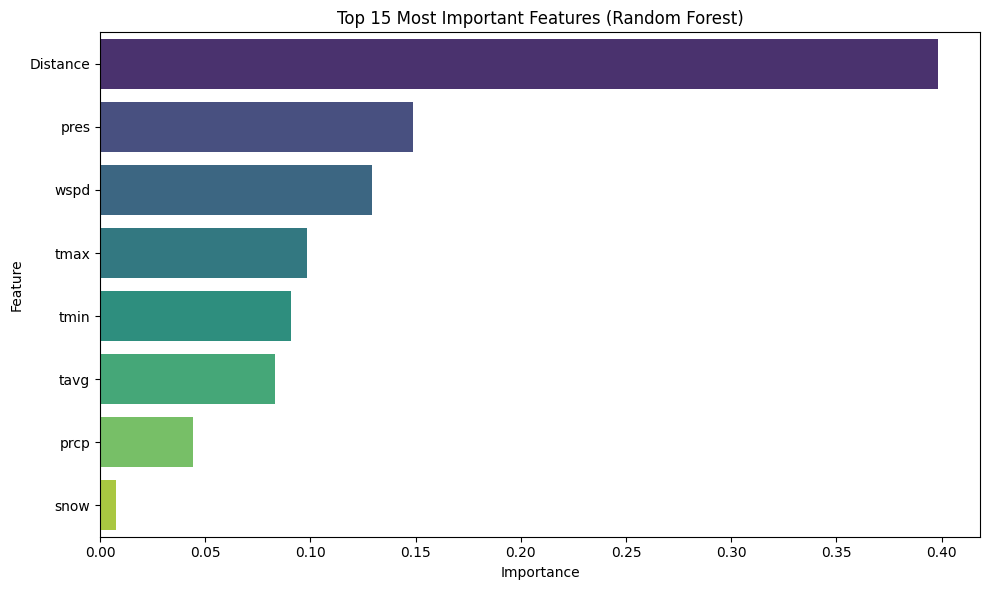

In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Select relevant numeric features
features = ['Distance', 'wspd', 'tavg', 'prcp', 'pres', 'snow', 'tmin', 'tmax']

# One-hot encode categorical variables
one_hot_cols = [col for col in df.columns if col.startswith('Origin_') or col.startswith('Month_') or col.startswith('DayOfWeek_') or col.startswith('Dest_')]

# Target variable
target = 'DepDelayMinutes'

# Define X and y
X = df[features + one_hot_cols]
y = df[target]

X_sample = X.sample(500_000, random_state = 42)
y_sample = y.loc[X_sample.index]

X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42
)

# =========================
# 5️⃣ Train Random Forest
# =========================
rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    max_depth=30,
    min_samples_split=2,
    min_samples_leaf=1
)
rf.fit(X_train, y_train)

# =========================
# 6️⃣ Evaluate model
# =========================
y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
# rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("✅ Model Performance:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.3f}")

# =========================
# 7️⃣ Feature importance plot
# =========================
importances = pd.DataFrame({
    'Feature': X_sample.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importances.head(15), palette='viridis')
plt.title("Top 15 Most Important Features (Random Forest)")
plt.tight_layout()
plt.show()
